#Imports


In [1]:
from google.colab.patches import cv2_imshow
import cv2
import os
import numpy as np
import keras
import glob
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Activation , Dropout, Flatten, BatchNormalization
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections
from keras.layers import  MaxPooling2D
from keras.layers import Conv2D
from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
map_categoria = {
    0: "baja", 1:"media", 2:"alta"
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

#Modelo para clasificar la complejidad

## Cargar Set

In [4]:
def load_set(dirname, map_categoria, verbose=True, img_size=64):
    """
    Versión compacta de la función load_set
    """
    X = []
    y = []

    # Formatos soportados
    formats = {
        '.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif',
        '.webp', '.gif', '.ppm', '.pgm', '.pbm',
        '.JPG', '.JPEG', '.PNG', '.BMP', '.TIFF', '.TIF'
    }

    for label, folder in map_categoria.items():
        folder_path = os.path.join(dirname, folder)

        if not os.path.exists(folder_path):
            continue

        images_loaded = 0
        for file in os.listdir(folder_path):
            if Path(file).suffix.lower() in formats:
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)

                if img is not None:
                    X.append(cv2.resize(img, (img_size, img_size)))
                    y.append(label)
                    images_loaded += 1

        if verbose:
            print(f"Cargadas {images_loaded} imágenes de {folder}")

    return np.array(X), np.array(y)

## Cargar Resnet50

In [5]:
def create_resnet50_model(num_classes=3, img_size=64, learning_rate=0.001):
    """
    Crea modelo ResNet50 con transfer learning

    Args:
        num_classes (int): Número de clases (baja, media, alta)
        img_size (int): Tamaño de imagen de entrada
        learning_rate (float): Tasa de aprendizaje

    Returns:
        model: Modelo de Keras compilado
    """

    # Cargar ResNet50 pre-entrenado en ImageNet (sin capas superiores)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )

    # Congelar capas base inicialmente
    base_model.trainable = False

    # Añadir nuevas capas para nuestra tarea
    inputs = keras.Input(shape=(img_size, img_size, 3))

    # Preprocesamiento específico de ResNet50
    x = tf.keras.applications.resnet50.preprocess_input(inputs)

    # Pasar por el modelo base
    x = base_model(x, training=False)

    # Capas personalizadas
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Crear modelo
    model = Model(inputs, outputs)

    # Compilar modelo
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

## Separar data entre train, test y val

In [6]:
def prepare_data(X, y, test_size=0.2, validation_size=0.2, img_size=64):
    """
    Prepara los datos para entrenamiento

    Args:
        X: Array de imágenes
        y: Array de etiquetas
        test_size: Proporción para test
        validation_size: Proporción para validación
        img_size: Tamaño objetivo para redimensionar

    Returns:
        tuple: Datos divididos y aumentados
    """

    # Redimensionar imágenes si es necesario (ResNet50 espera 224x224)
    if X.shape[1:3] != (img_size, img_size):
        X_resized = []
        for img in X:
            img_resized = tf.image.resize(img, [img_size, img_size])
            X_resized.append(img_resized)
        X = np.array(X_resized)

    # Dividir datos
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=validation_size, random_state=42, stratify=y_temp
    )

    print(f"📊 Distribución de datos:")
    print(f"   Entrenamiento: {X_train.shape[0]} imágenes")
    print(f"   Validación: {X_val.shape[0]} imágenes")
    print(f"   Test: {X_test.shape[0]} imágenes")

    return X_train, X_val, X_test, y_train, y_val, y_test

## Augmentation de la data

In [7]:
def create_data_generators(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=10):
    """
    Crea generadores de datos con data augmentation
    """

    # Data augmentation para entrenamiento
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Solo reescalar para validación y test
    val_test_datagen = ImageDataGenerator()

    # Crear generadores
    train_generator = train_datagen.flow(
        X_train, y_train, batch_size=batch_size, shuffle=True
    )

    val_generator = val_test_datagen.flow(
        X_val, y_val, batch_size=batch_size, shuffle=False
    )

    test_generator = val_test_datagen.flow(
        X_test, y_test, batch_size=batch_size, shuffle=False
    )

    return train_generator, val_generator, test_generator

## Entrenando a la resnet50

In [8]:
def train_resnet50_model(X, y, num_classes=3, epochs=50, batch_size=10):
    """
    Entrena el modelo ResNet50

    Args:
        X: Array de imágenes
        y: Array de etiquetas
        num_classes: Número de clases
        epochs: Número de épocas
        batch_size: Tamaño del batch

    Returns:
        tuple: Modelo entrenado e historia de entrenamiento
    """

    # Preparar datos
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(X, y)

    # Crear generadores
    train_gen, val_gen, test_gen = create_data_generators(
        X_train, X_val, X_test, y_train, y_val, y_test, batch_size
    )
    print("train_gen.shape")
    print(len(train_gen))
    print("val_gen.shape")
    print(len(val_gen))
    print("test_gen.shape")
    print(len(test_gen))

    # Crear modelo
    model, base_model = create_resnet50_model(num_classes=num_classes)

    print("🧠 Arquitectura del modelo:")
    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'mejor_modelo_resnet50.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]

    print("🚀 Comenzando entrenamiento...")

    # Fase 1: Entrenar solo capas superiores
    history1 = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    # Fase 2: Fine-tuning (descongelar capas finales de ResNet50)
    print("\n🔧 Comenzando fine-tuning...")

    # Descongelar las últimas capas del modelo base
    base_model.trainable = True

    # Congelar las primeras capas
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    # Recompilar con learning rate más bajo
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tuning
    history2 = model.fit(
        train_gen,
        epochs=epochs // 2,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    # Combinar historiales
    history = {
        'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
        'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
        'loss': history1.history['loss'] + history2.history['loss'],
        'val_loss': history1.history['val_loss'] + history2.history['val_loss']
    }

    # Evaluar modelo final
    print("\n📊 Evaluando modelo final...")
    test_loss, test_accuracy = model.evaluate(test_gen, verbose=0)
    print(f"✅ Precisión en test: {test_accuracy:.4f}")
    print(f"✅ Pérdida en test: {test_loss:.4f}")

    return model, history, (X_test, y_test)


## Graficos

In [9]:
def plot_training_history(history):
    """
    Grafica la historia del entrenamiento
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfica de precisión
    ax1.plot(history['accuracy'], label='Precisión Entrenamiento')
    ax1.plot(history['val_accuracy'], label='Precisión Validación')
    ax1.set_title('Precisión del Modelo')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Precisión')
    ax1.legend()
    ax1.grid(True)

    # Gráfica de pérdida
    ax2.plot(history['loss'], label='Pérdida Entrenamiento')
    ax2.plot(history['val_loss'], label='Pérdida Validación')
    ax2.set_title('Pérdida del Modelo')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Pérdida')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('historia_entrenamiento.png', dpi=300, bbox_inches='tight')
    plt.show()


## Evaluar modelo

In [10]:
def evaluate_model(model, X_test, y_test, class_names):
    """
    Evalúa el modelo y muestra métricas detalladas
    """
    # Predecir
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Reporte de clasificación
    print("\n📈 Reporte de Clasificación:")
    print(classification_report(y_test, y_pred_classes, target_names=class_names))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.savefig('matriz_confusion.png', dpi=300, bbox_inches='tight')
    plt.show()


## Ejecutar todo

In [11]:
map_categoria = {
        0: "baja",
        1: "media",
        2: "alta"
    }

class_names = ["baja", "media", "alta"]
DATASET_PATH_COLAB = "drive/MyDrive/8vo Semestre/Python/complejidad"

X, y = load_set(DATASET_PATH_COLAB, map_categoria)

    # Verificar que tenemos datos
if len(X) == 0:
    print("❌ No se cargaron imágenes. Verifica la ruta y formato de archivos.")
    exit()

Cargadas 141 imágenes de baja
Cargadas 178 imágenes de media
Cargadas 156 imágenes de alta


🚀 Iniciando entrenamiento de ResNet50...
📊 Distribución de datos:
   Entrenamiento: 304 imágenes
   Validación: 76 imágenes
   Test: 95 imágenes
train_gen.shape
38
val_gen.shape
10
test_gen.shape
12
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
🧠 Arquitectura del modelo:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 64, 64)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 64, 64)    │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 64, 64)    │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 64, 64, 3) │          0 │ get_item[0][0],   │
│                     │                   │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64, 3) │          0 │ stack[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2, 2,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2048)      │      8,192 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        771 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,777,091 (94.52 MB)

 Trainable params: 1,185,283 (4.52 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

🚀 Comenzando entrenamiento...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4361 - loss: 1.5303
Epoch 1: val_accuracy improved from -inf to 0.40789, saving model to mejor_modelo_resnet50.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 268ms/step - accuracy: 0.4400 - loss: 1.5318 - val_accuracy: 0.4079 - val_loss: 2.4197 - learning_rate: 0.0010
Epoch 2/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5377 - loss: 1.2382
Epoch 2: val_accuracy improved from 0.40789 to 0.46053, saving model to mejor_modelo_resnet50.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5385 - loss: 1.2365 - val_accuracy: 0.4605 - val_loss: 1.6150 - learning_rate: 0.0010
Epoch 3/50
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6400 - loss: 1.0062
Epoch 3: val_accuracy improved from 0.46053 to 0.52632, saving model to mejor_modelo_resnet50.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6358 - loss: 1.0143 - val_accuracy: 0.5263 - val_loss: 1.6178 - learning_rate: 0.0010
Epoch 4/50
36/38 ━━━━━━━━━━━━━━━━━━━━

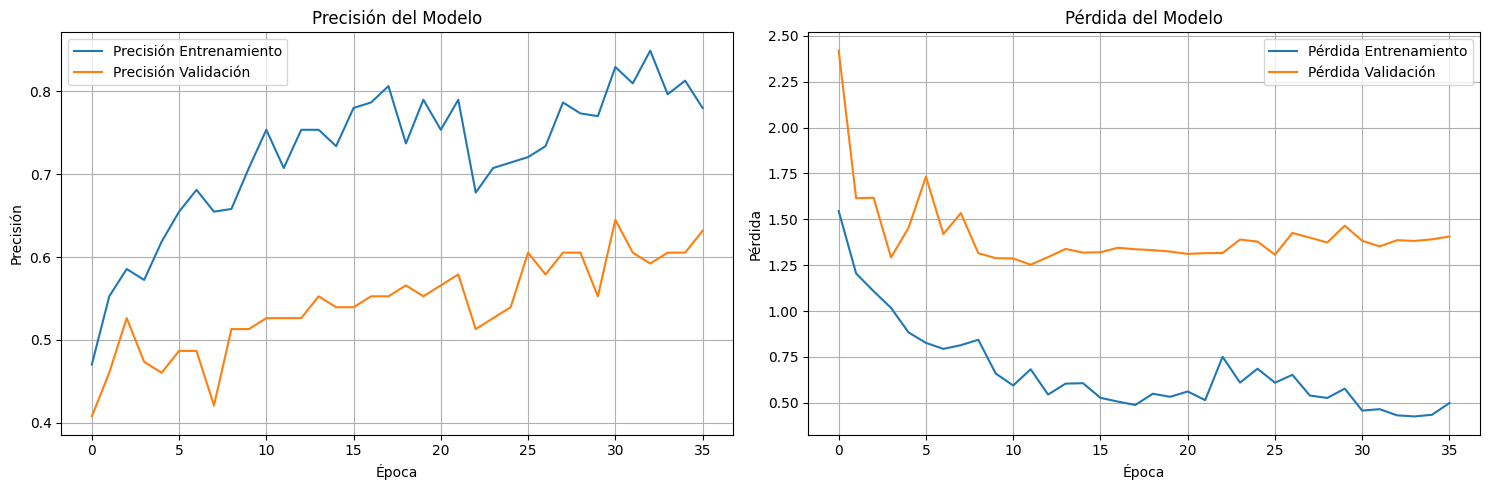

In [12]:
# 2. Entrenar modelo
print("🚀 Iniciando entrenamiento de ResNet50...")
model, history, test_data = train_resnet50_model(
        X, y,
        num_classes=3,
        epochs=50,  # Puedes ajustar según tu dataset
        batch_size=8  # Puedes ajustar según tu GPU
)

    # 3. Visualizar resultados
plot_training_history(history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step

📈 Reporte de Clasificación:
              precision    recall  f1-score   support

        baja       0.71      0.61      0.65        28
       media       0.54      0.58      0.56        36
        alta       0.56      0.58      0.57        31

    accuracy                           0.59        95
   macro avg       0.60      0.59      0.60        95
weighted avg       0.60      0.59      0.59        95



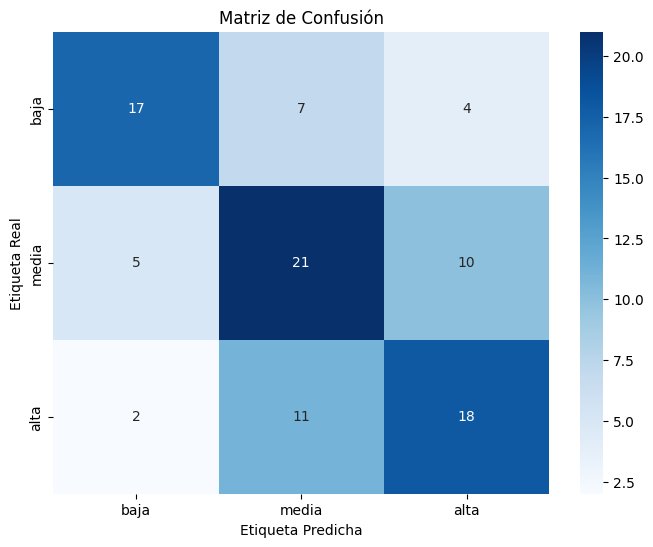

💾 Modelo guardado como 'modelo_resnet50_complejidad_obras.keras'


In [13]:
# 4. Evaluación detallada
X_test, y_test = test_data
evaluate_model(model, X_test, y_test, class_names)

    # 5. Guardar modelo final
model.save('modelo_resnet50_complejidad_obras.keras')
print("💾 Modelo guardado como 'modelo_resnet50_complejidad_obras.keras'")

In [14]:
# 6. Ejemplo de predicción
print("\n🎯 Ejemplo de predicción:")
sample_idx = 5
sample_image = X_test[sample_idx]
true_label = y_test[sample_idx]

prediction = model.predict(np.expand_dims(sample_image, axis=0))
predicted_class = np.argmax(prediction[0])
confidence = np.max(prediction[0])

print(f"   Imagen real: {class_names[true_label]}")
print(f"   Predicción: {class_names[predicted_class]}")
print(f"   Confianza: {confidence:.4f}")


🎯 Ejemplo de predicción:
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
   Imagen real: alta
   Predicción: alta
   Confianza: 0.8073


# Modelo para predecir las horas estimadas

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import pandas as pd
import os

In [16]:
def create_resnet50_regression_model(img_size=64, learning_rate=0.001):
    """
    Crea modelo ResNet50 para REGRESIÓN (predecir horas)

    Args:
        img_size (int): Tamaño de imagen de entrada
        learning_rate (float): Tasa de aprendizaje

    Returns:
        model: Modelo de Keras compilado para regresión
    """

    # Cargar ResNet50 pre-entrenado en ImageNet (sin capas superiores)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )

    # Congelar capas base inicialmente
    base_model.trainable = False

    # Añadir nuevas capas para REGRESIÓN
    inputs = keras.Input(shape=(img_size, img_size, 3))

    # Preprocesamiento específico de ResNet50
    x = tf.keras.applications.resnet50.preprocess_input(inputs)

    # Pasar por el modelo base
    x = base_model(x, training=False)

    # Capas personalizadas para regresión
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Capa de salida para REGRESIÓN (1 neurona, sin activación)
    outputs = Dense(1, activation='linear')(x)

    # Crear modelo
    model = Model(inputs, outputs)

    # Compilar modelo para REGRESIÓN
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',  # Error cuadrático medio
        metrics=['mae']  # Error absoluto medio
    )

    return model, base_model

In [17]:
def load_regression_dataset(dirname, verbose=True, img_size=64):
    """
    Carga dataset para regresión basado en carpetas con nombres numéricos

    Args:
        dirname (str): Directorio base con carpetas nombradas por horas
        verbose (bool): Si mostrar información de progreso
        img_size (int): Tamaño para redimensionar imágenes

    Returns:
        tuple: (X, y) donde X son imágenes e y son horas
    """

    X = []
    y = []

    # Formatos de imagen soportados
    supported_formats = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}

    # Buscar todas las carpetas (cada carpeta representa horas)
    if not os.path.exists(dirname):
        print(f"❌ Directorio no encontrado: {dirname}")
        return np.array([]), np.array([])

    folders = [f for f in os.listdir(dirname) if os.path.isdir(os.path.join(dirname, f))]

    if verbose:
        print(f"📁 Carpetas encontradas: {folders}")

    for folder in folders:
        try:
            # Convertir nombre de carpeta a número (horas)
            hours = float(folder)
            folder_path = os.path.join(dirname, folder)

            # Buscar imágenes en la carpeta
            image_files = []
            for file in os.listdir(folder_path):
                file_ext = os.path.splitext(file)[1].lower()
                if file_ext in supported_formats:
                    image_files.append(file)

            if verbose:
                print(f"📥 Cargando {len(image_files)} imágenes de carpeta '{folder}' horas")

            # Procesar cada imagen
            successful_images = 0
            for image_name in image_files:
                try:
                    image_path = os.path.join(folder_path, image_name)

                    # Leer imagen con OpenCV
                    image = cv2.imread(image_path)

                    if image is not None:
                        # Redimensionar
                        resized_image = cv2.resize(image, (img_size, img_size))
                        X.append(resized_image)
                        y.append(hours)
                        successful_images += 1

                except Exception as e:
                    if verbose:
                        print(f"⚠️ Error con {image_name}: {e}")
                    continue

            if verbose:
                print(f"✅ Cargadas {successful_images} imágenes para {hours} horas")

        except ValueError:
            if verbose:
                print(f"⚠️ Saltando carpeta '{folder}' - no es un número válido")
            continue

    X_array = np.array(X)
    y_array = np.array(y)

    if verbose:
        print(f"\n📊 Dataset cargado:")
        print(f"   Total imágenes: {len(X_array)}")
        print(f"   Rango de horas: {y_array.min()} - {y_array.max()}")
        print(f"   Forma de X: {X_array.shape}")
        print(f"   Forma de y: {y_array.shape}")

    return X_array, y_array

In [18]:
def prepare_regression_data(X, y, test_size=0.2, validation_size=0.2, img_size=64):
    """
    Prepara los datos para entrenamiento de regresión
    """

    # Redimensionar imágenes si es necesario
    if len(X) > 0 and X.shape[1:3] != (img_size, img_size):
        X_resized = []
        for img in X:
            img_resized = tf.image.resize(img, [img_size, img_size])
            X_resized.append(img_resized)
        X = np.array(X_resized)

    # Dividir datos
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=validation_size, random_state=42
    )

    print(f"📊 Distribución de datos:")
    print(f"   Entrenamiento: {X_train.shape[0]} imágenes")
    print(f"   Validación: {X_val.shape[0]} imágenes")
    print(f"   Test: {X_test.shape[0]} imágenes")
    print(f"   Rango horas entrenamiento: {y_train.min():.1f} - {y_train.max():.1f}")

    return X_train, X_val, X_test, y_train, y_val, y_test

In [19]:
def create_regression_generators(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    """
    Crea generadores de datos con data augmentation para regresión
    """

    # Data augmentation para entrenamiento
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Solo reescalar para validación y test
    val_test_datagen = ImageDataGenerator()

    # Crear generadores
    train_generator = train_datagen.flow(
        X_train, y_train, batch_size=batch_size, shuffle=True
    )

    val_generator = val_test_datagen.flow(
        X_val, y_val, batch_size=batch_size, shuffle=False
    )

    test_generator = val_test_datagen.flow(
        X_test, y_test, batch_size=batch_size, shuffle=False
    )

    return train_generator, val_generator, test_generator

In [20]:
def train_resnet50_regression(X, y, epochs=50, batch_size=32):
    """
    Entrena el modelo ResNet50 para regresión

    Returns:
        tuple: Modelo entrenado e historia de entrenamiento
    """

    # Preparar datos
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_regression_data(X, y)

    # Crear generadores
    train_gen, val_gen, test_gen = create_regression_generators(
        X_train, X_val, X_test, y_train, y_val, y_test, batch_size
    )

    # Crear modelo
    model, base_model = create_resnet50_regression_model()

    print("🧠 Arquitectura del modelo de regresión:")
    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'mejor_modelo_resnet50_regression.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]

    print("🚀 Comenzando entrenamiento de regresión...")

    # Fase 1: Entrenar solo capas superiores
    history1 = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    # Fase 2: Fine-tuning
    print("\n🔧 Comenzando fine-tuning...")

    # Descongelar las últimas capas del modelo base
    base_model.trainable = True

    # Congelar las primeras capas
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    # Recompilar con learning rate más bajo
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )

    # Fine-tuning
    history2 = model.fit(
        train_gen,
        epochs=epochs // 2,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    # Combinar historiales
    history = {
        'loss': history1.history['loss'] + history2.history['loss'],
        'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
        'mae': history1.history['mae'] + history2.history['mae'],
        'val_mae': history1.history['val_mae'] + history2.history['val_mae']
    }

    # Evaluar modelo final
    print("\n📊 Evaluando modelo final...")
    test_loss, test_mae = model.evaluate(test_gen, verbose=0)
    print(f"✅ Error absoluto medio (MAE) en test: {test_mae:.2f} horas")
    print(f"✅ Error cuadrático medio (MSE) en test: {test_loss:.2f}")

    return model, history, (X_test, y_test)


In [21]:
def plot_regression_training_history(history):
    """
    Grafica la historia del entrenamiento para regresión
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfica de pérdida
    ax1.plot(history['loss'], label='Pérdida Entrenamiento')
    ax1.plot(history['val_loss'], label='Pérdida Validación')
    ax1.set_title('Pérdida del Modelo (MSE)')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('MSE')
    ax1.legend()
    ax1.grid(True)

    # Gráfica de MAE
    ax2.plot(history['mae'], label='MAE Entrenamiento')
    ax2.plot(history['val_mae'], label='MAE Validación')
    ax2.set_title('Error Absoluto Medio (MAE)')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('MAE (horas)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('historia_entrenamiento_regresion.png', dpi=300, bbox_inches='tight')
    plt.show()


In [22]:
def evaluate_regression_model(model, X_test, y_test):
    """
    Evalúa el modelo de regresión y muestra métricas
    """
    # Predecir
    y_pred = model.predict(X_test).flatten()

    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("\n📈 Métricas de Regresión:")
    print(f"   Error Absoluto Medio (MAE): {mae:.2f} horas")
    print(f"   Error Cuadrático Medio (MSE): {mse:.2f}")
    print(f"   Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f} horas")
    print(f"   Coeficiente de Determinación (R²): {r2:.4f}")

    # Gráfico de predicciones vs reales
    plt.figure(figsize=(10, 6))

    # Línea de perfecta predicción
    max_val = max(max(y_test), max(y_pred))
    min_val = min(min(y_test), min(y_pred))

    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Predicción Perfecta')

    # Scatter plot
    plt.scatter(y_test, y_pred, alpha=0.6, s=50)
    plt.xlabel('Horas Reales')
    plt.ylabel('Horas Predichas')
    plt.title('Predicciones vs Valores Reales')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Añadir texto con métricas
    plt.text(0.05, 0.95, f'MAE: {mae:.2f} horas\nR²: {r2:.4f}',
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8),
             verticalalignment='top')

    plt.savefig('evaluacion_regresion.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Histograma de errores
    errors = y_pred - y_test
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Error (Horas Predichas - Horas Reales)')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Errores de Predicción')
    plt.axvline(x=0, color='r', linestyle='--', label='Error Cero')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('distribucion_errores.png', dpi=300, bbox_inches='tight')
    plt.show()

    return y_pred

In [23]:
X, y = load_regression_dataset("drive/MyDrive/8vo Semestre/Python/Horas_Estimadas_IMG", verbose=True, img_size=64)

    # Verificar que tenemos datos
if len(X) == 0:
  print("❌ No se cargaron imágenes. Verifica la estructura de carpetas.")
  print("   Estructura esperada: dataset/train/2/, dataset/train/8/, etc.")
  exit()

📁 Carpetas encontradas: ['2.5', '2', '3', '5', '4', '6', '12', '15', '18', '20', '35', '24', '50', '70', '150', '0.5', '1.5', '0.75', '1', '8', '80', '40', '100', '16', '7', '320', '38', '37']
📥 Cargando 3 imágenes de carpeta '2.5' horas
✅ Cargadas 3 imágenes para 2.5 horas
📥 Cargando 27 imágenes de carpeta '2' horas
✅ Cargadas 27 imágenes para 2.0 horas
📥 Cargando 6 imágenes de carpeta '3' horas
✅ Cargadas 6 imágenes para 3.0 horas
📥 Cargando 25 imágenes de carpeta '5' horas
✅ Cargadas 25 imágenes para 5.0 horas
📥 Cargando 25 imágenes de carpeta '4' horas
✅ Cargadas 25 imágenes para 4.0 horas
📥 Cargando 26 imágenes de carpeta '6' horas
✅ Cargadas 26 imágenes para 6.0 horas
📥 Cargando 2 imágenes de carpeta '12' horas
✅ Cargadas 2 imágenes para 12.0 horas
📥 Cargando 24 imágenes de carpeta '15' horas
✅ Cargadas 24 imágenes para 15.0 horas
📥 Cargando 3 imágenes de carpeta '18' horas
✅ Cargadas 3 imágenes para 18.0 horas
📥 Cargando 25 imágenes de carpeta '20' horas
✅ Cargadas 25 imágenes p

🚀 Iniciando entrenamiento de ResNet50 para regresión...
📊 Distribución de datos:
   Entrenamiento: 304 imágenes
   Validación: 76 imágenes
   Test: 95 imágenes
   Rango horas entrenamiento: 0.5 - 320.0
🧠 Arquitectura del modelo de regresión:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 64, 64)    │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 64, 64)    │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 64, 64)    │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 64, 64, 3) │          0 │ get_item_3[0][0], │
│                     │                   │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64, 3) │          0 │ stack_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2, 2,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │  1,049,088 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        129 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,809,345 (94.64 MB)

 Trainable params: 1,217,537 (4.64 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

🚀 Comenzando entrenamiento de regresión...
Epoch 1/60


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2314.3291 - mae: 25.0999
Epoch 1: val_loss improved from inf to 3753.07642, saving model to mejor_modelo_resnet50_regression.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 248ms/step - loss: 2333.2510 - mae: 25.3007 - val_loss: 3753.0764 - val_mae: 31.4281 - learning_rate: 0.0010
Epoch 2/60
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1840.0007 - mae: 24.1835
Epoch 2: val_loss improved from 3753.07642 to 3742.34668, saving model to mejor_modelo_resnet50_regression.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 1875.0173 - mae: 24.3204 - val_loss: 3742.3467 - val_mae: 28.1751 - learning_rate: 0.0010
Epoch 3/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2068.2705 - mae: 22.8230
Epoch 3: val_loss improved from 3742.34668 to 2917.93945, saving model to mejor_modelo_resnet50_regression.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 2060.7002 - mae: 22.8226 - val_loss: 2917.9395 - val_mae: 29.5558 - learning_rate: 0.0010
Epoch 4/60


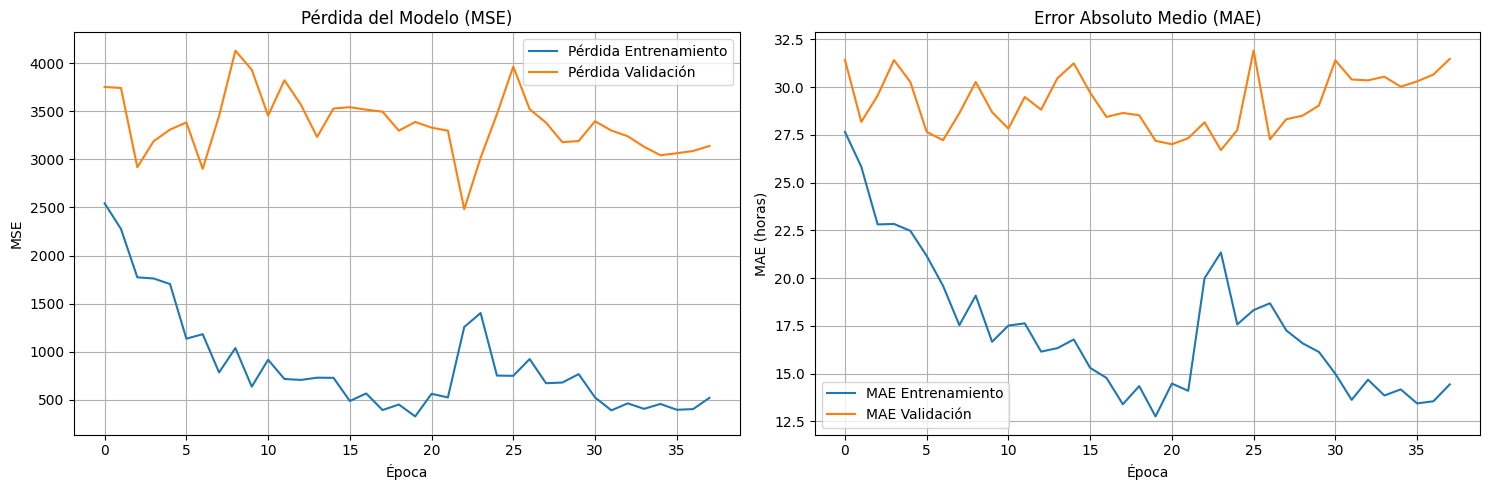

In [24]:
print("🚀 Iniciando entrenamiento de ResNet50 para regresión...")
model, history, test_data = train_resnet50_regression(
        X, y,
        epochs=60,
        batch_size=8
    )

plot_regression_training_history(history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step

📈 Métricas de Regresión:
   Error Absoluto Medio (MAE): 42.56 horas
   Error Cuadrático Medio (MSE): 7675.18
   Raíz del Error Cuadrático Medio (RMSE): 87.61 horas
   Coeficiente de Determinación (R²): 0.2043


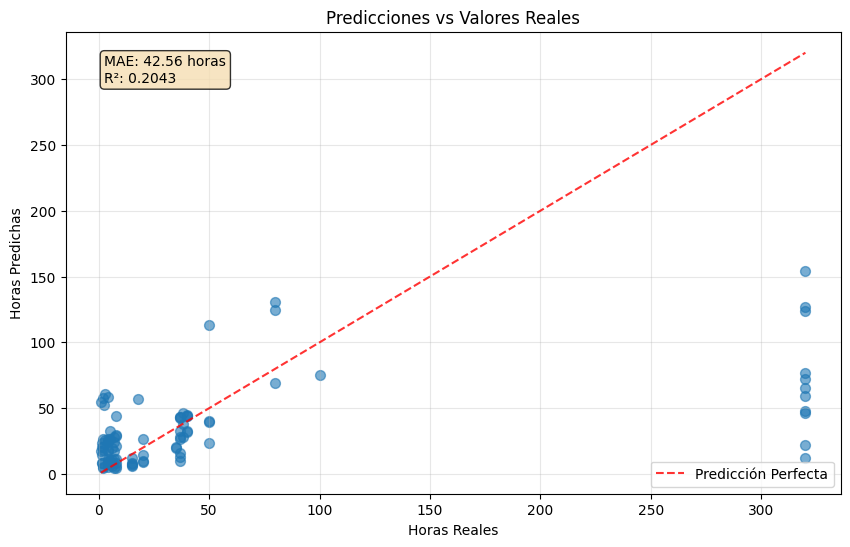

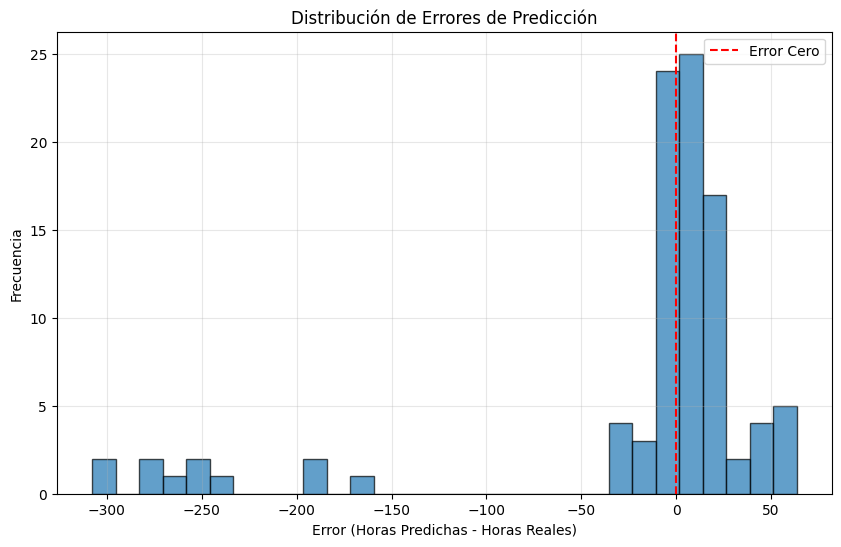

💾 Modelo guardado como 'modelo_resnet50_prediccion_horas.h5'


In [25]:
X_test, y_test = test_data
y_pred = evaluate_regression_model(model, X_test, y_test)
model.save('modelo_resnet50_prediccion_horas.keras')
print("💾 Modelo guardado como 'modelo_resnet50_prediccion_horas.h5'")